This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse

# set the gpu via OS environment variable
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_E-11_F0002"
    ).resolve(strict=True)

    clip_limit = 0.05

In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  6651.25


## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
print(len(files))

78


In [5]:
image_dict = {
    "nuclei_file_paths": [],
    "nuclei": [],
    "cytoplasm1": [],
    "cytoplasm2": [],
    "cytoplasm3": [],
}

In [6]:
nuclei_mask_image_list = []
for file in files:
    if "C01" in file.split("/")[-1]:
        image_dict["nuclei_file_paths"].append(file)
        image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
    elif "C02" in file.split("/")[-1]:
        image_dict["cytoplasm1"].append(tifffile.imread(file).astype(np.float32))
    elif "C03" in file.split("/")[-1]:
        image_dict["cytoplasm2"].append(tifffile.imread(file).astype(np.float32))
    elif "C04" in file.split("/")[-1]:
        image_dict["cytoplasm3"].append(tifffile.imread(file).astype(np.float32))
    elif "nuclei" in file.split("/")[-1]:
        nuclei_mask_image_list.append(tifffile.imread(file).astype(np.float32))

    cytoplasm_image_list = [
        np.max(
            np.array(
                [
                    nuclei,
                    cytoplasm1,
                    cytoplasm2,
                    cytoplasm3,
                ]
            ),
            axis=0,
        )
        for nuclei, cytoplasm1, cytoplasm2, cytoplasm3 in zip(
            image_dict["nuclei"],
            image_dict["cytoplasm1"],
            image_dict["cytoplasm2"],
            image_dict["cytoplasm3"],
        )
    ]
cyto = np.array(cytoplasm_image_list).astype(np.int16)

cyto = skimage.exposure.equalize_adapthist(cyto, clip_limit=clip_limit)

# seeded watershed segmentation

In [7]:
masks_all_dict = {
    "nuclei_masks": [],
    "cytoplasm_images": [],
    "cytoplasm_masks": [],
}

In [8]:
from scipy import ndimage

# set the seeds
from skimage import filters, measure, morphology, segmentation

# Create seeds from nuclei

for timepoint in range(len(image_dict["nuclei_file_paths"])):
    frame = image_dict["nuclei_file_paths"][timepoint]
    cell_mask_filename = f"{str(frame).split('/')[-1].split('_C01')[0]}_cell_mask.tiff"
    watershed_seeds = measure.label(nuclei_mask_image_list[timepoint], connectivity=1)
    # Dilate nuclei to create cytoplasm boundaries
    intensity_threshold = np.percentile(cyto[timepoint], 50)  # Adjust percentile
    cyto_mask = cyto[timepoint] > intensity_threshold

    cytoplasm_mask = segmentation.watershed(
        filters.sobel(cyto[timepoint]), markers=watershed_seeds, mask=cyto_mask
    )
    # dilate the cytoplasm mask to ensure it covers the cytoplasm
    cytoplasm_mask = morphology.dilation(
        cytoplasm_mask, morphology.disk(1)
    )  # Adjust radius

    # Store the results
    masks_all_dict["nuclei_masks"].append(nuclei_mask_image_list[timepoint])
    masks_all_dict["cytoplasm_images"].append(cyto[timepoint])
    masks_all_dict["cytoplasm_masks"].append(cytoplasm_mask)
    tifffile.imwrite(pathlib.Path(input_dir / cell_mask_filename), cytoplasm_mask)

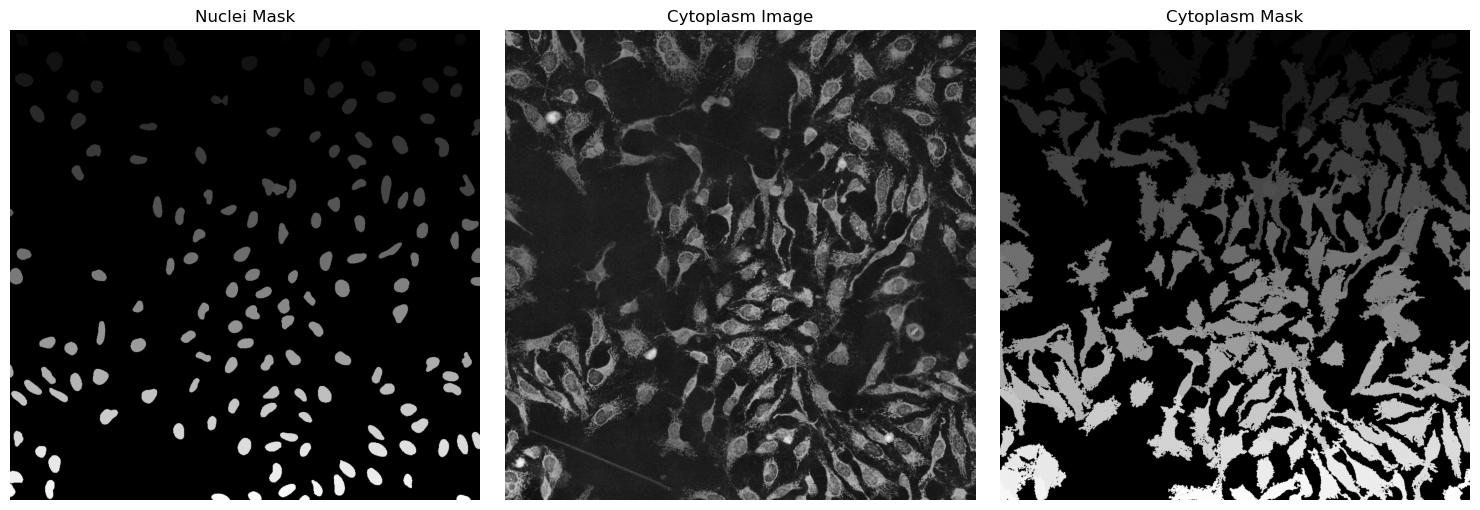

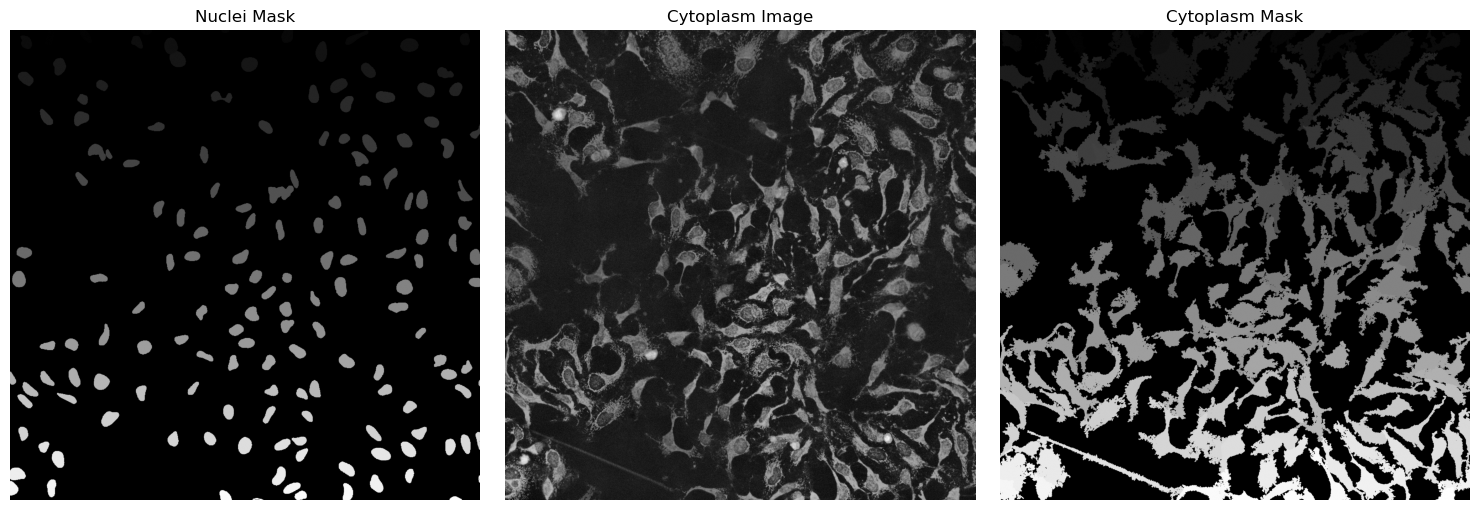

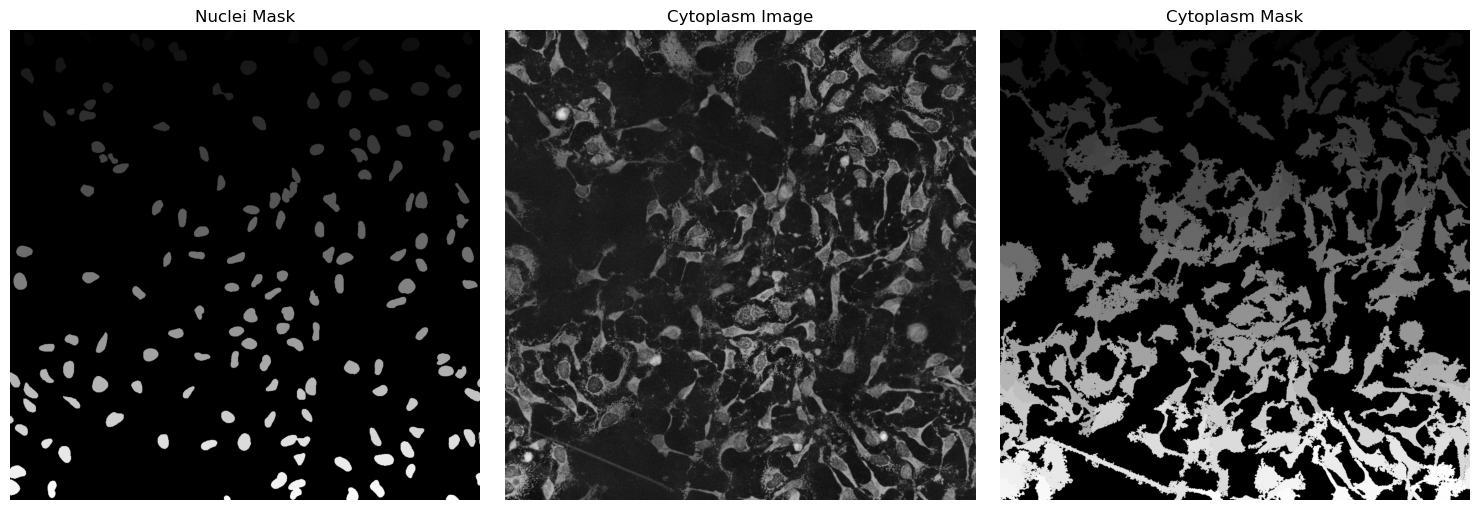

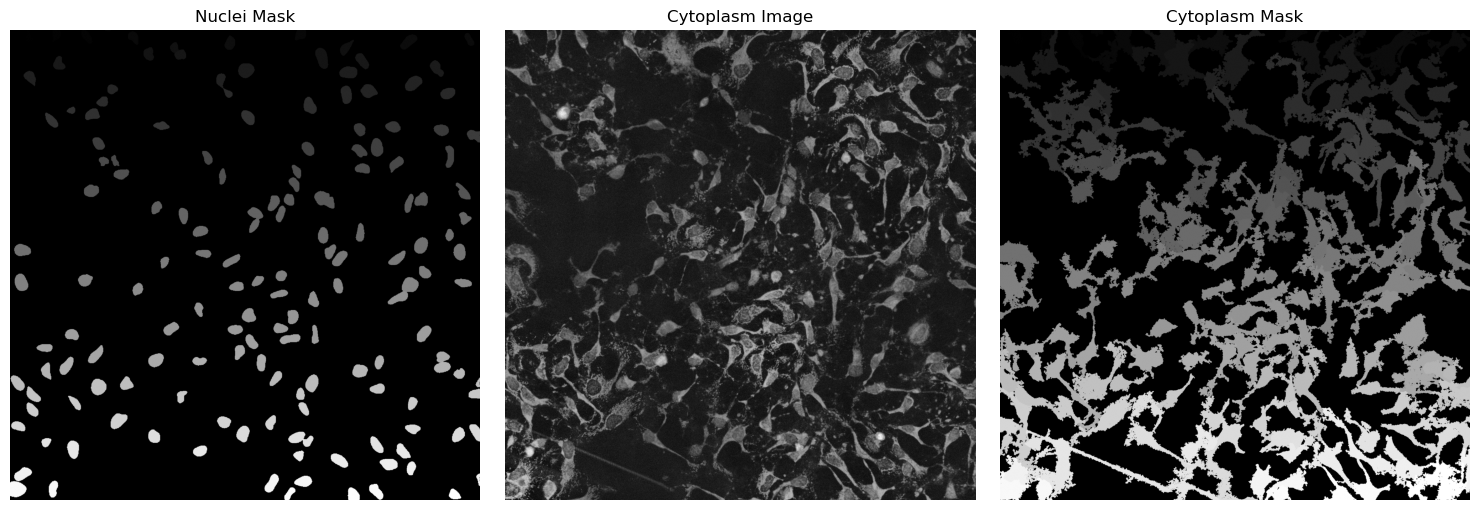

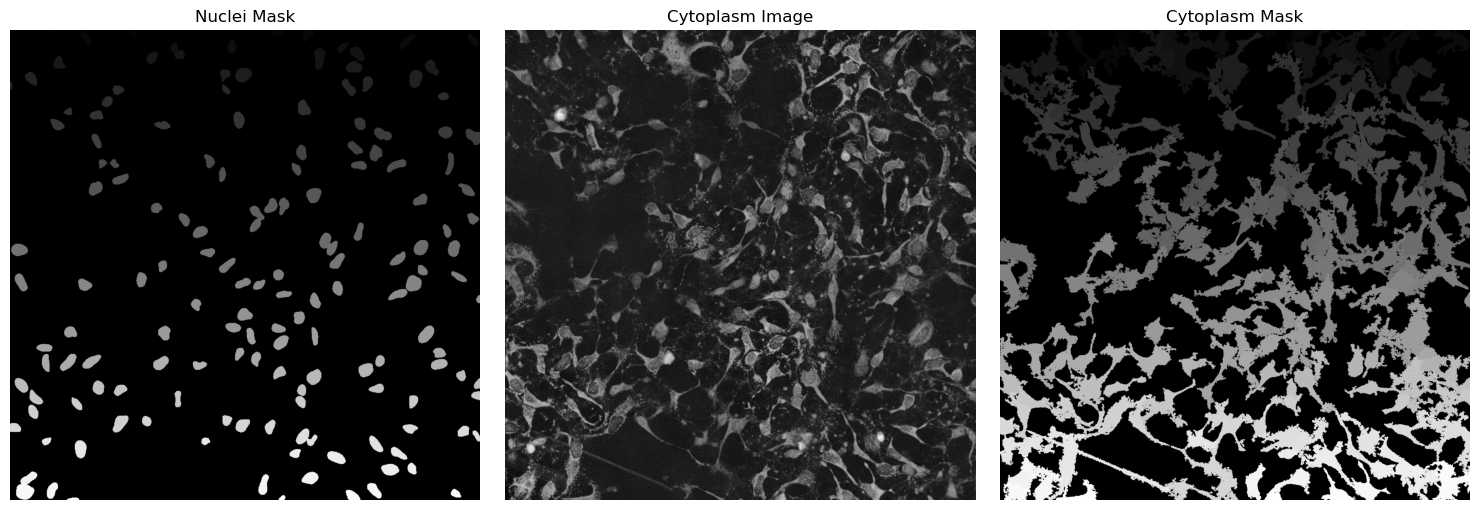

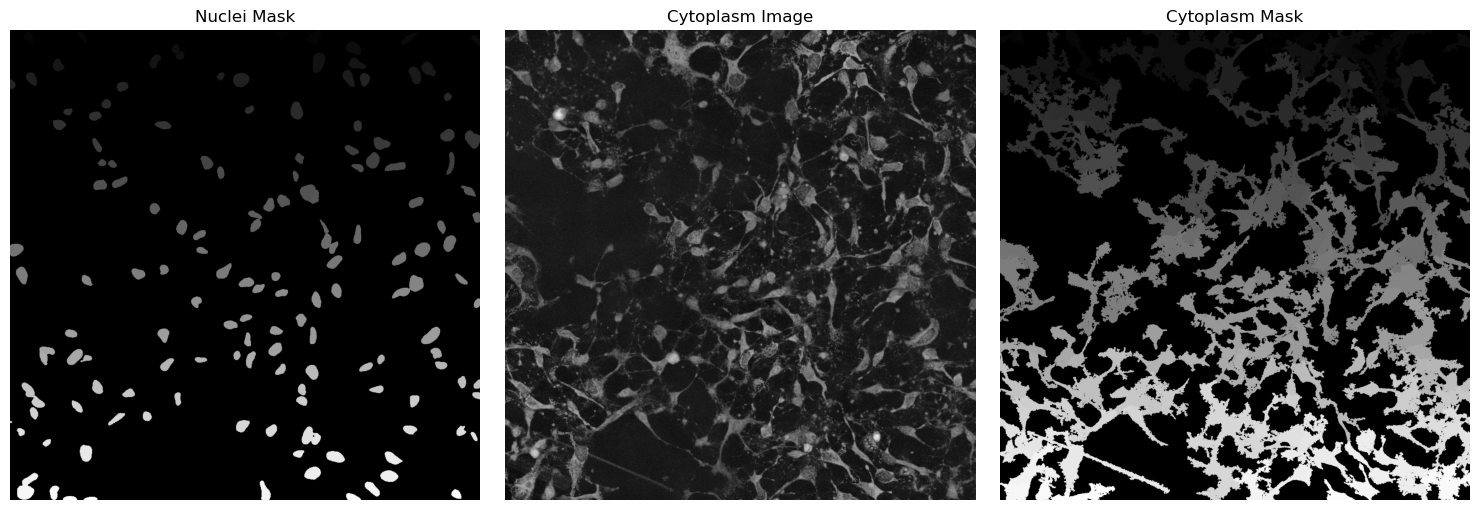

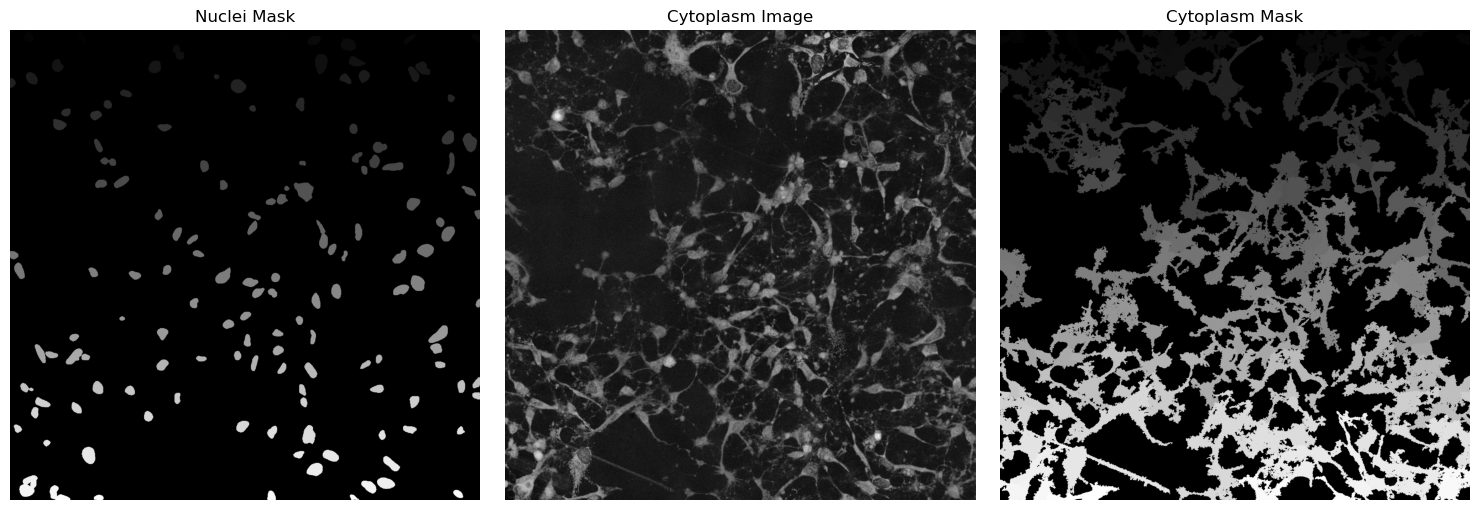

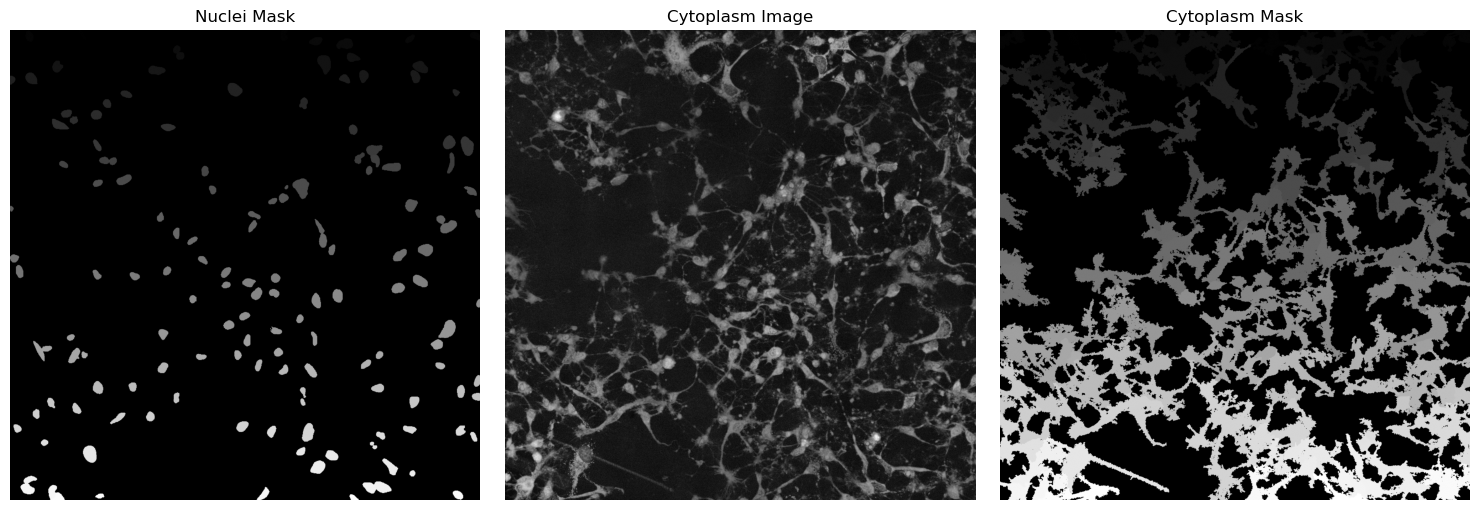

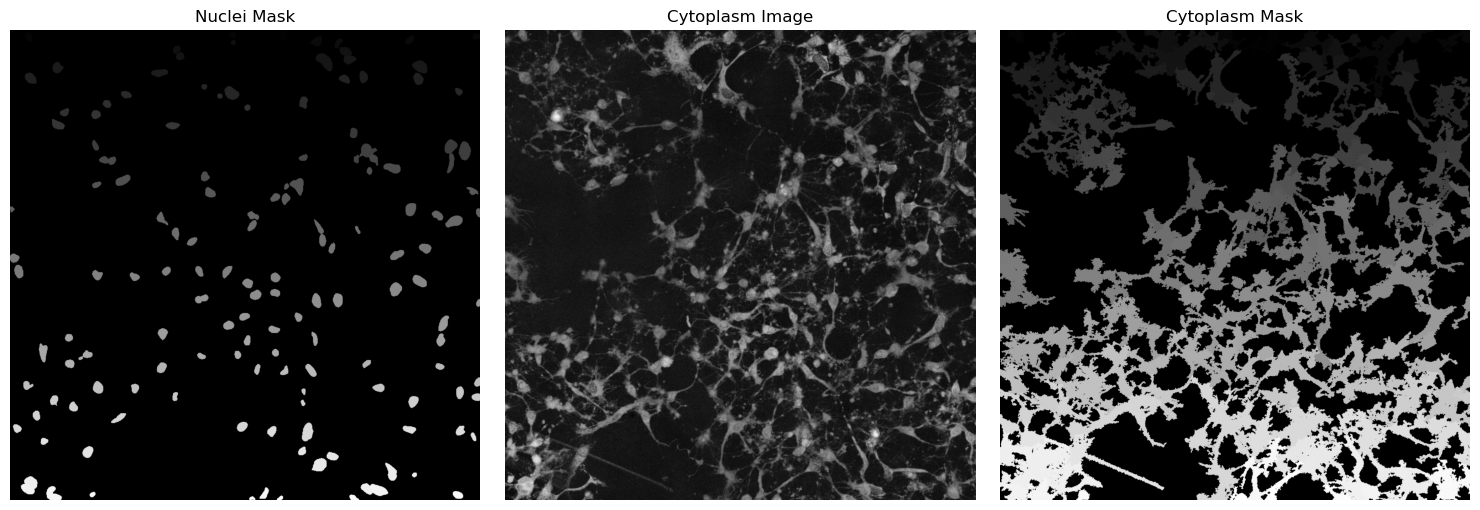

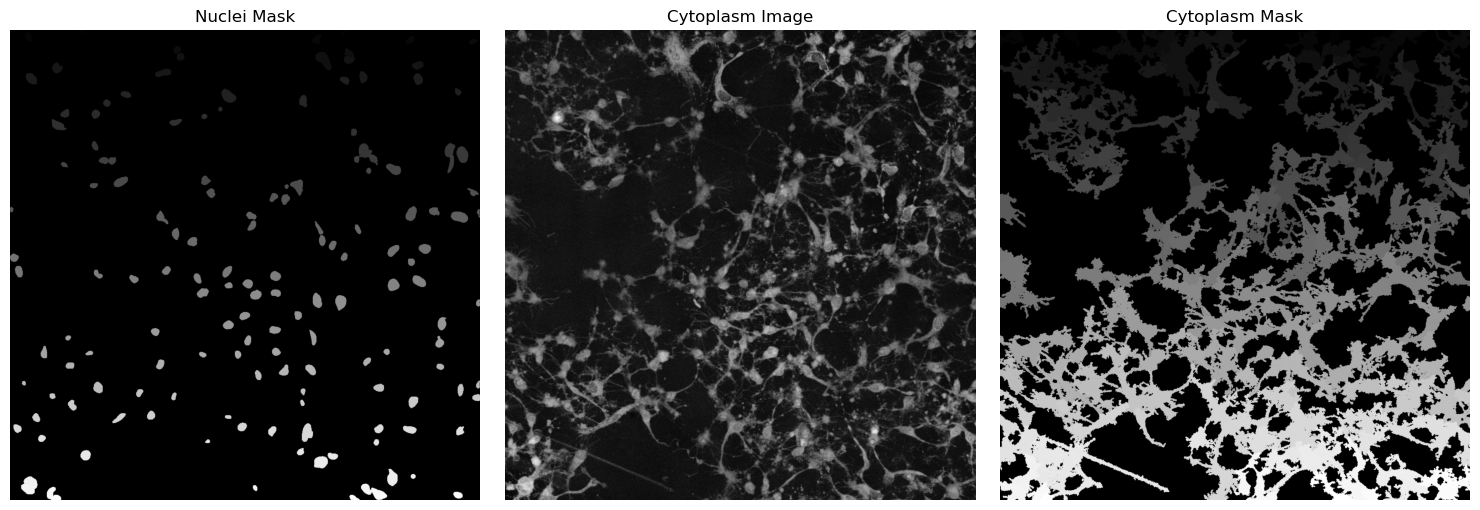

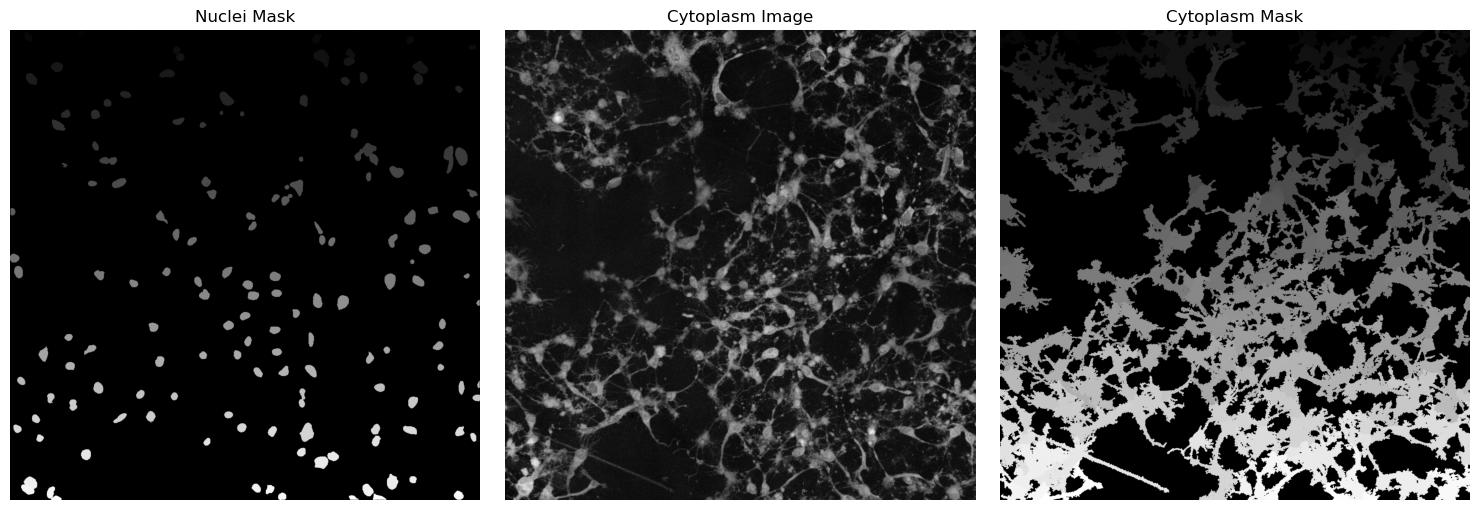

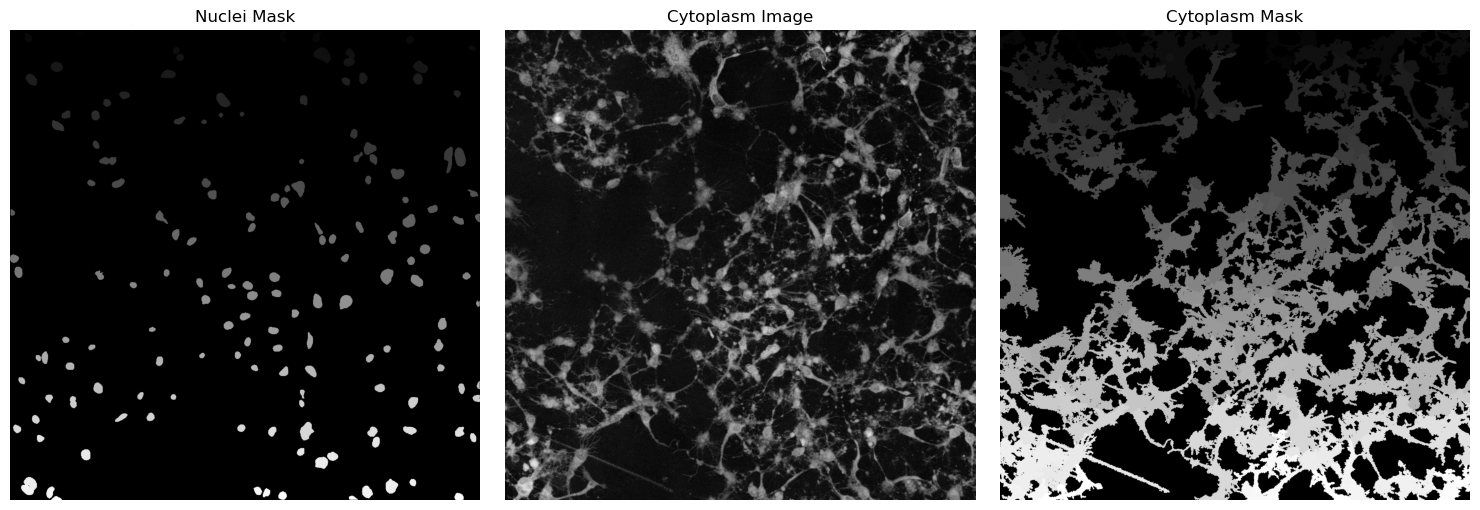

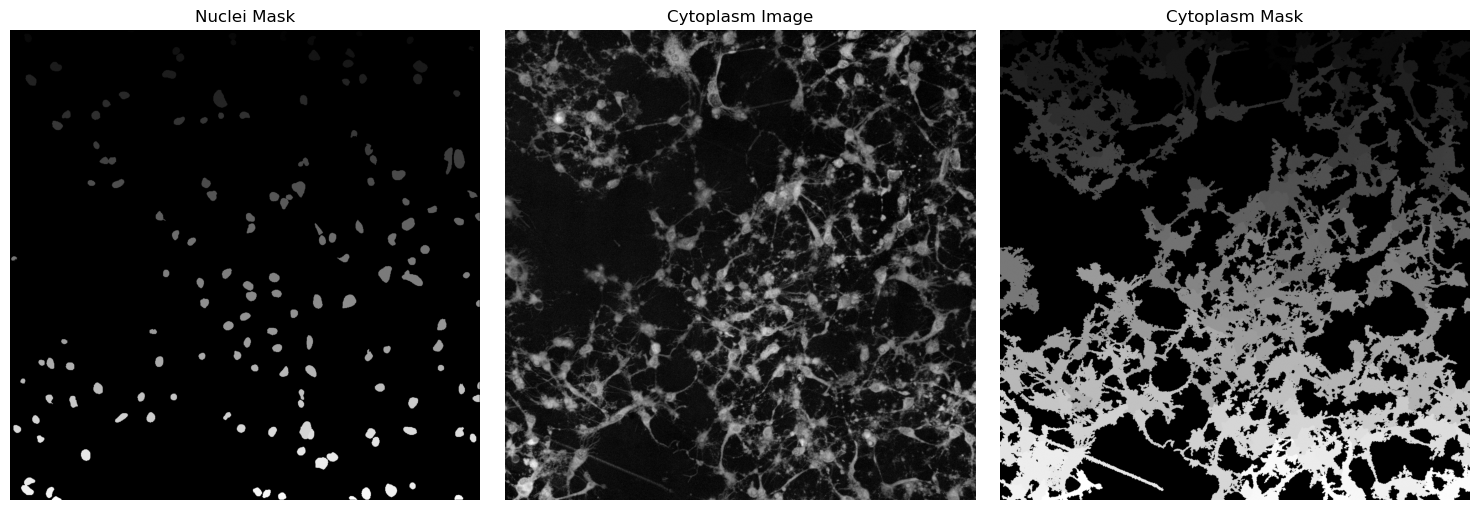

In [9]:
if in_notebook:
    for timepoint in range(len(masks_all_dict["cytoplasm_masks"])):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(nuclei_mask_image_list[timepoint], cmap="gray")
        plt.title("Nuclei Mask")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(cyto[timepoint], cmap="gray")
        plt.title("Cytoplasm Image")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(masks_all_dict["cytoplasm_masks"][timepoint], cmap="gray")
        plt.title("Cytoplasm Mask")
        plt.axis("off")
        plt.tight_layout()
        plt.show()